In [212]:
import numpy as np
from numpy import *
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import cm

import cv2

   

%matplotlib inline



def draw(pointList, makeVideo=False):
       
    
    fig, ax = plt.subplots()

    plt.ylim(0.0, 100.0)
    plt.xlim(0.0, 100.0)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(linestyle='--')


    #--------------------draw pockets--------------------    
    alphaValue = 0.4
    for pt in corners:
        ax.add_artist(plt.Circle(pt, epsilon1, color='orange', alpha=alphaValue))
        #make the fallPocket red
    ax.add_artist(plt.Circle((sideLen/2, sideLen/2), epsilon2, color='orange', alpha=alphaValue))
    
    #make the fallPocket red
    if fallPocket==(sideLen/2, sideLen/2):
        ax.add_artist(plt.Circle(fallPocket, epsilon2, color='red', alpha=alphaValue))
    else:
        ax.add_artist(plt.Circle(fallPocket, epsilon1, color='red', alpha=alphaValue))
    #--------------------draw trajectory---------------
    xList = []
    yList = []
    for pt in pointList:
        xList.append(pt[0])
        yList.append(pt[1])
    
    colors = cm.rainbow(np.linspace(0, 1, len(xList)))
    
    images=[]
    for i in range(len(xList)-1):
        plt.plot(xList[i:i+2], yList[i:i+2], color=colors[i], marker='o')
        imgName = 'images/' + str(i) + '.png'
        plt.savefig(imgName)
        images.append(cv2.imread(imgName))
    
    plt.title("Trajectroy: p0=" + str(pointList[0]) + ", p1=" + str(pointList[1]))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    
    
    print("len(images) =", len(images))
    
    
    #--------------------now make video---------------
    if makeVideo:
        
        height,width,layers=images[1].shape
        video=cv2.VideoWriter('billiard.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 5, (width,height))

        for j in range(len(images)):
            video.write(images[j])

        cv2.destroyAllWindows()
        video.release()

        print("Video Done!")

    
    
    
   
  

In [213]:
#sides = 0, 1, 2, 3 (bottom, right, top, left)
sideLen = 100
corners = [(0,0), (sideLen, 0), (sideLen, sideLen), (0, sideLen)]

#given a side s, return its endpoints (x1 ,y1, x2, y2)

sideCoords = []
sideCoords.append([0,0, sideLen, 0])#bottom side
sideCoords.append([sideLen,0, sideLen, sideLen])#right side
sideCoords.append([sideLen,sideLen, 0, sideLen])#top side
sideCoords.append([0,sideLen, 0, 0])#left side

    

In [214]:
def getSide(pt):
    x,y = pt
    if x==0:
        return 3
    if x==sideLen:
        return 1
    if y==0:
        return 0
    if y==sideLen:
        return 2

In [215]:
# input: point_i (pi), point_i+1 (pil), line_i (li), side_i (si)
# output: point_i+1 (piNew), point_i+2 (piNextNew), line_i+1 (liNew), side_i (siNew)

#siNext is the side of piNext

def getNextPoint(pi, piNext):

    temp = [sideLen, sideLen, 0, 0]
    siNext = getSide(piNext)
#     -------------------------------------------------------------------------------
    if siNext%2==1: #1, or 3
            
        newy = 0
        if piNext[1] > pi[1]:
            newy = sideLen # axis = horizontal,    expect newy=sideLen or 0
#         print("expect newy = ", newy)
        
        
        if siNext==1:
            newx = piNext[0] -  abs( (piNext[0]-pi[0]) * (newy-piNext[1]) / (piNext[1]-pi[1]) )
        else:#siNext==3
            newx = piNext[0]  +  abs( (piNext[0]-pi[0]) * (newy-piNext[1]) / (piNext[1]-pi[1]) )
            
#         print("tan = ", abs( (piNext[0]-pi[0]) / (piNext[1]-pi[1]) ))
#         print("temp newx =", newx)

        if not (0 <= newx and newx <= sideLen):  #si increments two
#             print("increment two")
            
            newx = 0
            if piNext[0] < pi[0]:
                newx = sideLen
            
            if piNext[1] > pi[1]:
                newy = piNext[1]    +   abs((piNext[1]-pi[1]) * (piNext[0] - newx) /  (piNext[0] - pi[0]))
            else:
                newy = piNext[1]    -   abs((piNext[1]-pi[1]) * (piNext[0] - newx) /  (piNext[0] - pi[0]))
    
    
#     -------------------------------------------------------------------------------
    if siNext%2==0: #2, or 0(4)

            
        newx = 0
        if piNext[0] > pi[0]:
            newx = sideLen # axis = vertical,    expect newy=sideLen or 0
        
#         print("expect newx =", newx)
        
        if siNext==2:
            newy = piNext[1] -   abs( (piNext[1]-pi[1]) * (newx-piNext[0]) / (piNext[0]-pi[0]) )
#             print("expect newy =", newy)
        else:#siNext==0
            newy = piNext[1] +   abs( (piNext[1]-pi[1]) * (newx-piNext[0]) / (piNext[0]-pi[0]) )
    

    
        if not (0 <= newy and newy <= sideLen):  #si increments two
#             print("increment two")
            
            newy = 0
            if piNext[1] < pi[1]:
                newy = sideLen
            
            if piNext[0] > pi[0]:
                newx = piNext[0]    +  abs((piNext[0]-pi[0]) * (piNext[1] - newy) /  (piNext[1] - pi[1]))
            else:
                newx = piNext[0]    -  abs((piNext[0]-pi[0]) * (piNext[1] - newy) /  (piNext[1] - pi[1]))
    

        
    return (newx, newy)


In [216]:

def pointDist(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    return np.sqrt((x1-x2)**2 + (y1-y2)**2 )
    
#distance between ptC and the line segment: (ptA to ptB)
def dist(A, B, C):
    x1, y1 = A
    x2, y2 = B
    x3, y3 = C
    
    a = pointDist(B, C)
    b = pointDist(A, C)
    c = pointDist(A, B)
    
    cosA = (b**2+c**2-a**2) / (2*b*c)
    cosB = (a**2+c**2-b**2) / (2*a*c)
    k = (y2-y1) / (x2-x1)
    b = y1-k*x1
    if cosA > 0 and cosB > 0:# both angles A and B < 90
        return abs(y3 - k*x3 - b) / np.sqrt(1**2 + (-k)**2)
    else:
        return min(a, b)
    

def fall(pt1, pt2):
    global fallPocket
    for pt in corners:
        if dist(pt1, pt2, pt) < epsilon1:
            print("Fall into pocket: ", pt)
            fallPocket = pt
            return True
    centerPt = (sideLen/2, sideLen/2)
    if dist(pt1, pt2, centerPt) < epsilon2:
        fallPocket = centerPt
        print("Fall into CENTER pocket: ", centerPt)
        return True
    
    return False

In [217]:
def billiard(p0, p1, ptList):
    
    pi = p0
    piNext = p1
    
    count = 0
    while(True):
#         print("pi =", pi, "  piNext =", piNext)
        
        count+=1
        newx, newy = getNextPoint(pi, piNext)
        
        pi = piNext
        piNext = (newx, newy)
        
        ptList.append(piNext)
        if fall(pi, piNext):
            break
#         if count > 100:
#             print("COUNT OF LINE SEGMENTS > 100, WE STOP!")
#             break
        

In [218]:
epsilon1 = 6
epsilon2 = 3

Fall into pocket:  (100, 0)


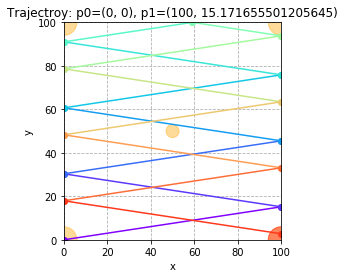

len(images) = 14


In [219]:
p0 = (0,0)
p1 = (100, 100/6.59123851)
s1 = getSide(p1)

ptList = [p0, p1]
global fallPocket
fallPocket = (999, 999)

billiard(p0, p1, ptList)
# print("ptList =", ptList)

draw(ptList, makeVideo=False)


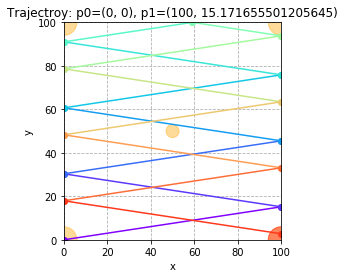

len(images) = 14
Video Done!


In [220]:
draw(ptList, makeVideo=True)

In [221]:
# draw(ptList, makeVideo=True)